# Power Outages
This project uses major power outage data in the continental U.S. from January 2000 to July 2016. Here, a major power  outage is defined as a power outage that impacted at least 50,000 customers or caused an unplanned firm load loss of atleast 300MW. Interesting questions to consider include:
- Where and when do major power outages tend to occur?
- What are the characteristics of major power outages with higher severity? Variables to consider include location, time, climate, land-use characteristics, electricity consumption patterns, economic characteristics, etc. What risk factors may an energy company want to look into when predicting the location and severity of its next major power outage?
- What characteristics are associated with each category of cause?
- How have characteristics of major power outages changed over time? Is there a clear trend?

### Getting the Data
The data is downloadable [here](https://engineering.purdue.edu/LASCI/research-data/outages/outagerisks).

A data dictionary is available at this [article](https://www.sciencedirect.com/science/article/pii/S2352340918307182) under *Table 1. Variable descriptions*.

### Cleaning and EDA
- Note that the data is given as an Excel file rather than a CSV. Open the data in Excel or another spreadsheet application and determine which rows and columns of the Excel spreadsheet should be ignored when loading the data in pandas.
- Clean the data.
    - The power outage start date and time is given by `OUTAGE.START.DATE` and `OUTAGE.START.TIME`. It would be preferable if these two columns were combined into one datetime column. Combine `OUTAGE.START.DATE` and `OUTAGE.START.TIME` into a new datetime column called `OUTAGE.START`. Similarly, combine `OUTAGE.RESTORATION.DATE` and `OUTAGE.RESTORATION.TIME` into a new datetime column called `OUTAGE.RESTORATION`.
- Understand the data in ways relevant to your question using univariate and bivariate analysis of the data as well as aggregations.

*Hint 1: pandas can load multiple filetypes: `pd.read_csv`, `pd.read_excel`, `pd.read_html`, `pd.read_json`, etc.*

*Hint 2: `pd.to_datetime` and `pd.to_timedelta` will be useful here.*

*Tip: To visualize geospatial data, consider [Folium](https://python-visualization.github.io/folium/) or another geospatial plotting library.*

### Assessment of Missingness
- Assess the missingness of a column that is not missing by  design.

### Hypothesis Test
Find a hypothesis test to perform. You can use the questions at the top of the notebook for inspiration.

# Summary of Findings

## Introduction

The North American Electric Reliability Corporation, hereafter referred to as NERC, is a non-profit, non-governmental organization whose goal is to create and sustain a more reliable and sufficient power grid for the US and Canada. Currently, NERC holds the title of "Electric Reliability Organization" (ERO), which was created by the Energy Policy Act of 2005 and whose role is to enforce compliance with safety and quality standards for the electric industry. Since the Energy Policy Act came into effect in early 2006, I thought a reasonable use of the dataset, hereafter referred to as `outage`, downloaded from the provided link would be to investigate whether there were significant changes in the causes of outages before and after 2006.

Below, the dataset `outage` is imported from an Excel file.

In [831]:
outage = outage_xlsx_to_df()
outage.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
1,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
2,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
3,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
4,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874


Further inspection of the dataset reveals that it is in need of cleaning, which is described below.

As can be seen, the `outage` dataset describes characteristics of each outage recorded, of which there were 1534.

## Cleaning and EDA

The primary issue that I found with `outage` is that 705 of the 1534 rows in the column `DEMAND.LOSS.MW`, which describes the amount of peak demand lost during an outage event, are missing. The significance of this missingness is that the classification of what constitutes a major power outage event depends on `DEMAND.LOSS.MW` and `CUSTOMERS.AFFECTED` (which describes how many customers were affected by the outage event) - namely, an outage is said to be "major" if the demand lost is above 300 megawatts or the number of customers affected is above 50,000. 

The column `CUSTOMERS.AFFECTED` faces a missingness problem (440 out of 1534) similar to the one faced by `DEMAND.LOSS.MW` described above. 

Hence, classification of outages as "major" will be hindered unless some sort of imputation (i.e., filling in missing data with probable data points) is carried out.

A secondary issue was that originally, the year/month/day columns describing when an outage started and when power was restored did not align with the either the duration of the outage (that information is held in the `DURATION` column). Since many more entries in `DURATION` columns than in the `YEAR`, `MONTH`, `DAY`, `OUTAGE.START.TIME`, and `OUTAGE.RESTORATION.TIME` columns were missing, I chose to replace them with entries inferred from the above columns by combining the latter group of columns into `OUTAGE.START.DATETIME` and `OUTAGE.RESTORATION.DATETIME` (in `pd.datetime` format), which is a timestamp.

There was an issue with the type of the data - most of it was stored as an object type, which could not be analyzed easily (eg, a groupby operation would not work with objects as I used groupby). Hence I cleaned `outage` appropriately to convert numeric data stored as objects into data stored as floats.

In [832]:
outage = combine_times(outage) # fixing columns of time
outage = fix_duration(outage) # enforcing consistency between columns that describe the same information
outage = fix_types(outage) # fixing the type of data

As previously mentioned, let's add a column titled `MAJOR.POWER.OUTAGE`, which will be true if an outage should be classified as major and false otherwise.

In [833]:
mpo = lambda row: row['CUSTOMERS.AFFECTED'] > 50_000 or row['DEMAND.LOSS.MW'] > 300
outage = outage.assign(**{'MAJOR.POWER.OUTAGE': outage.apply(mpo, axis=1)})

One of the first questions I had about `outages` was how missingness in the `DEMAND.LOSS.MW` column might differ by NERC region (the entity responsible for a specific region of NERC's jurisdiction). Below, I aggregate both what the average demand lost per outage (in megawatts) is, per NERC region, and the proportion of outages in which that NERC region reported `DEMAND.LOSS.MW`. As one can see, the latter quantity differs across NERC regions.

In [835]:
loss_by_region = (outage.get(['DEMAND.LOSS.MW', 'NERC.REGION'])
                  .assign(**{'DEMAND.LOSS.MW.NOTNULL': outage['DEMAND.LOSS.MW'].notnull()})
                  .groupby('NERC.REGION').mean())
loss_by_region.head()

,DEMAND.LOSS.MW,DEMAND.LOSS.MW.NOTNULL
NERC.REGION,,
ASCC,35.000000,1.000000
ECAR,1314.483871,0.911765
FRCC,804.450000,0.909091
"FRCC, SERC",NaN,0.000000
HECO,466.666667,1.000000


One might also wonder how many major power outages happen per year, per cause of outage. That information is displayed below, without `outage` having been given imputed values.

In [836]:
(outage.pivot_table(values='MAJOR.POWER.OUTAGE', 
                    index='CAUSE.CATEGORY', 
                    columns='YEAR', 
                    aggfunc='sum')
                    .fillna(0)
                    .astype(np.int)
)

YEAR,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
CAUSE.CATEGORY,,,,,,,,,,,,,,,,,
equipment failure,1,0,0,5,2,2,0,2,2,7,1,1,0,3,0,0,0
fuel supply emergency,0,0,0,0,0,0,1,0,0,0,0,3,2,1,4,1,0
intentional attack,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,2
islanding,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
public appeal,0,2,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
severe weather,10,0,12,29,46,39,49,36,69,40,60,94,56,42,29,40,11
system operability disruption,3,8,1,6,2,3,7,3,9,1,8,7,1,2,0,6,6


Another question might be whether price (cents per kilowatt-hour) of electricity increases as the GSP (gross state product) increases. Although this was not related to my hypothesis, I thought it was an interesting visualization. Below is price, on the x-axis, plotted against GSP, on the y-axis.

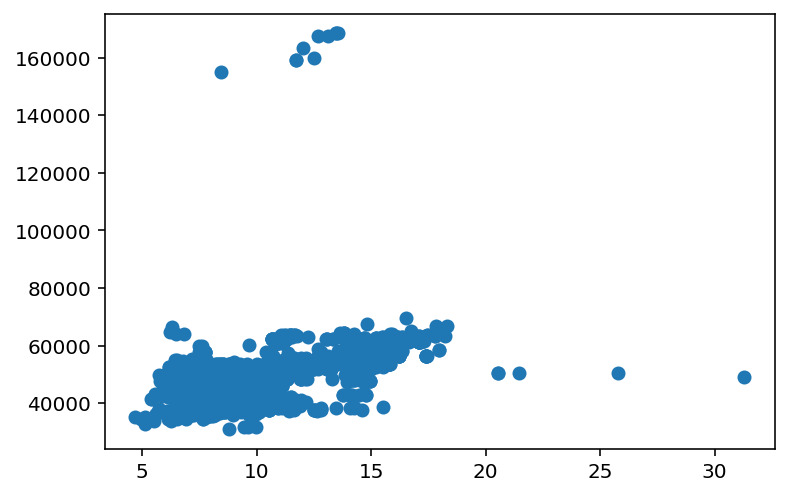

In [837]:
plt.scatter(outage['TOTAL.PRICE'], outage['PC.REALGSP.STATE'])

As consumers, we should want to expect that outages are resolved as soon as possible. So here is a histogram of how often power is restored. It seems that the vast majority 

(array([1.018e+03, 2.230e+02, 7.900e+01, 5.100e+01, 3.000e+01, 2.100e+01,
        1.800e+01, 5.000e+00, 7.000e+00, 6.000e+00, 5.000e+00, 2.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 0.        ,  1.50990278,  3.01980556,  4.52970833,  6.03961111,
         7.54951389,  9.05941667, 10.56931944, 12.07922222, 13.589125  ,
        15.09902778, 16.60893056, 18.11883333, 19.62873611, 21.13863889,
        22.64854167, 24.15844444, 25.66834722, 27.17825   , 28.68815278,
        30.19805556, 31.70795833, 33.21786111, 34.72776389, 36.23766667,
        37.

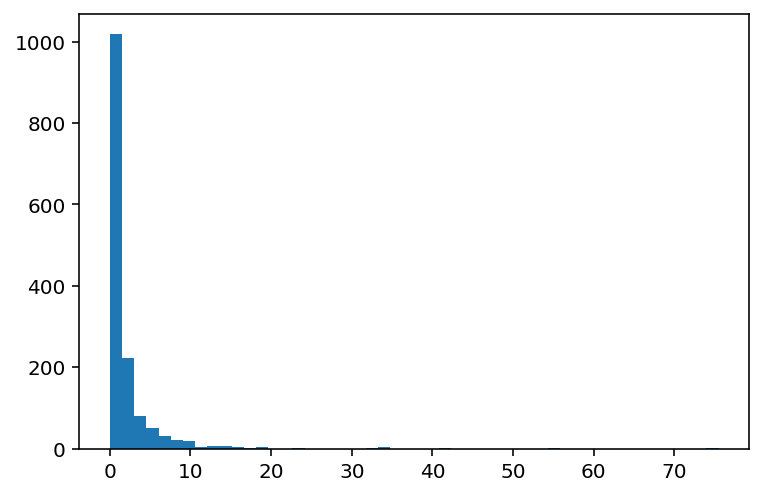

In [930]:
float_duration = outage['OUTAGE.DURATION'] / datetime.timedelta(days=1) # convert to number of days of outage
plt.hist(float_duration, bins=50)

In [929]:
outage['OUTAGE.DURATION'].describe()

count                         1476
mean     1 days 19:45:16.585365853
std      4 days 03:03:55.329295850
min                0 days 00:00:00
25%                0 days 01:42:15
50%                0 days 11:41:00
75%                2 days 00:00:00
max               75 days 11:53:00
Name: OUTAGE.DURATION, dtype: object

It seems that 75% of outages are resolved within two days.

## Assessment of Missingness

### Addressing potential NMAR in `DEMAND.LOSS.MW` and `CUSTOMERS.AFFECTED`

One issue that may be faced in the classification of outages as major or non-major is that the entries of `DEMAND.LOSS.MW` and in `CUSTOMERS.AFFECTED` may be NMAR, or not missing at random, meaning that the entries in these columns may be missing depending on their value. However, I do not believe that the data in either column is NMAR for the reasons listed below:

`DEMAND.LOSS.MW`: In one case, the data may be NMAR because of intentional underreporting by the member companies of NERC. However, I think the companies responsible for reporting `DEMAND.LOSS.MW` will face high barriers in intentional underreporting of `DEMAND.LOSS.MW` because I surmise that inherently, `DEMAND.LOSS.MW` is not a statistic that is measured explicitly by a sensor - it is a number that is extrapolated from (peak) consumption of electricity or a number measured right before the outage occurred. Since the numbers for electricity consumption are available freely, a company would not find much advantage in concealing `DEMAND.LOSS.MW` entries that could embarass itself because one could find data (provided in a different dataset than `outage`) that could help fill in the missing entries. Also, since `DEMAND.LOSS.MW` may be measured as a statistic taken right before the outage occurred, one could extrapolate from usage statistics taken right before the event what `DEMAND.LOSS.MW` could have been. Hence, the remaining case is that the data is NMAR unintentionally. 

The only case in which I think that could happen is that the cause of the outage is so severe that the sensors doing the data collection are burnt out during the event. But the US has not suffered (many) significant power outage events that could case such NMAR-ness to be significant, so I think it is safe to proceed under the assumption that the data is not NMAR.

`CUSTOMERS.AFFECTED`: I think this column is also not NMAR for reasons similar to those above.


With respect to data imputation, I think a reasonable strategy, regardless of whether `DEMAND.LOSS.MW` is NMAR, would be to examine the data in another dataset that contained the electricity consumption statistics for customers of companies in NERC by the hour from 2000 - 2016 (the time range that `outages` spans). I will assume that electricity consumption does not differ "significantly" on a timespan in the appropriate range - e.g., patterns of electricity consumption in the 29th week of the year does not "significantly" differ from the patterns of electricity consumption in the 30th week. Then, when `OUTAGE.START.TIME` is not null, we can extrapolate from the patterns of electricity consumption of the week prior to the outage what `DEMAND.LOSS.MW` should be, if `DEMAND.LOSS.MW` is null. Given the following statistics on the duration of outages:

In [498]:
outage['OUTAGE.DURATION'].describe()

count                         1476
mean     1 days 19:45:16.585365853
std      4 days 03:03:55.329295850
min                0 days 00:00:00
25%                0 days 01:42:15
50%                0 days 11:41:00
75%                2 days 00:00:00
max               75 days 11:53:00
Name: OUTAGE.DURATION, dtype: object

I think that since most outages are sufficiently short, a dataset on the patterns of electricity consumption could be used to impute the missing values in `DEMAND.LOSS.MW`, and a similar dataset could be used to impute `CUSTOMERS.AFFECTED`. However, since I think I should work within the confines of the supplied dataset, I chose not to do so. 

Instead, ideally I would employ groupwise **probabilistic** imputation, where the groups are determined by `U.S._STATE` and `YEAR`, since I expect outages within the same state and same year to have similar characteristics (the reason being that having fixed a time and place, most of the other characteristics, such as GSP per capita or residential/commercial/industrial character, lose significant effect in predicting missingness). However, because some states will go a year without an outage (thus causing us a loss in data), I choose to impute the missing values of `DEMAND.LOSS.MW` with just notnull values of that state, allowing `YEAR` to vary, along with a parameter to be specified.

Testing my guess with the functions `ks_missingness_pval` and `tvd_missinges_pval`, which quantify the p-value that the missingness of a given column is dependent on another column, it is found that if `U.S._STATE` is held fixed, the missingness of `DEMAND.LOSS.MW` looks more as though it was determined by randomly shuffling null and notnull rows. Because of how computationally expensive running these permutation tests is, I chose to run them on only three states: California, Texas, and Michigan, which I chose because they experienced more outages.

Here are the p-values for California, Texas, and Michigan:

In [599]:
pvals_compare_filtered.head()

,California,Texas,Michigan,ALL
CLIMATE.REGION,1.000000,1.000000,1.000000,0.000000
CLIMATE.CATEGORY,0.211060,0.002001,0.014000,0.147949
CAUSE.CATEGORY,0.693848,0.014000,0.042999,0.000000
OUTAGE.DURATION,0.068970,0.009003,0.101013,0.000000
CUSTOMERS.AFFECTED,0.001000,0.000000,0.151978,0.000000


The `ALL` column is the result of computing similar p-values without holding a state fixed. Per the above, holding a state fixed strongly reduces the likelihood that the missingness of `DEMAND.LOSS.MW` is dependent on a column (which is a row in the above dataframe). However, note that these are just the first five rows - the other rows are less successful.

However, even after holding a state fixed, there is still considerable variance in `DEMAND.LOSS.MW`, which I surmised to be caused by `CAUSE.CATEGORY`. Here is a quick visualization for five large states of how outages with different `CAUSE.CATEGORY`'s differed with respect to average `DEMAND.LOSS.MW`.

In [741]:
(outage.pivot_table(values='DEMAND.LOSS.MW', 
                    index='CAUSE.CATEGORY', 
                    columns='U.S._STATE', 
                    aggfunc='mean')
 .fillna(0)
 .astype(int)
 .transpose()
 .loc[['California', 'Texas', 'Michigan', 'Washington', 'New York']]
)

CAUSE.CATEGORY,equipment failure,fuel supply emergency,intentional attack,islanding,public appeal,severe weather,system operability disruption
U.S._STATE,,,,,,,
California,375,635,31,551,8638,412,335
Texas,378,1231,2,0,0,736,615
Michigan,336,0,0,0,8881,318,4197
Washington,244,630,0,94,100,430,200
New York,0,468,0,0,76,336,6975


So I additionally held constant the cause of the outage (this is the additional aforementioned parameter), and then used sampled observed data as the imputed data. You might wonder whether there were enough outages from which I could sample data, and there were not - in fact, there were 276 outages that did not have companion outages happening in the same state and were caused by the same cause. So I just dropped them, since those are probably outlier events as opposed to a kind of outage with a consistent pattern behind them. This was kind of unsatisfying, but I still imputed data for 705 - 276 outages, so it was partially successful. 

I did the same with `CUSTOMERS.AFFECTED`. If you are curious, here is a groupby for the average number of `CUSTOMERS.AFFECTED` with the same variables as above.

In [838]:
(outage.pivot_table(values='CUSTOMERS.AFFECTED', 
                    index='CAUSE.CATEGORY', 
                    columns='U.S._STATE', 
                    aggfunc='mean')
 .fillna(0)
 .astype(int)
 .transpose()
 .loc[['California', 'Texas', 'Michigan', 'Washington', 'New York']]
)

CAUSE.CATEGORY,equipment failure,fuel supply emergency,intentional attack,islanding,public appeal,severe weather,system operability disruption
U.S._STATE,,,,,,,
California,198608,0,10660,5039,0,361041,152040
Texas,85882,0,552,0,0,258094,289696
Michigan,0,0,0,0,0,138311,759737
Washington,93300,0,0,0,8000,182676,0
New York,0,0,0,0,18600,165050,1080998


## Find a column that is MCAR
`OUTAGE.DURATION` is **mostly** MCAR with all of the columns I included in my analysis of `outage`, since the result of running `ks_missingness_pval` and `tvd_missingness_pval` on it and on every other column in `outage` resulted in a relatively large p-value (higher than 0.01, the p-value that I will use in my hypothesis test, whose reasons for using I will explain below). Note that not all of them are greater than 0.01 - the ones that are not are:

`TOTAL.PRICE` `TOTAL.SALES`, `PC.REALGSP.USA`, `POPDEN_RURAL`, `OUTAGE.START.DATETIME`, and `OUTAGE.RESTORATION.DATETIME`. 

The last two are to be expected - `OUTAGE.DURATION` is formed by their difference, so of course its missingness would be dependent on those two. The others, however, are not as expected - my guess for the reason is that since these columns seem to be population or economic indicators, there are particular regions for which `OUTAGE.DURATION` is not reported. This may be correlated with `NERC.REGION`, but it did not show up in the p-value for `NERC.REGION` because each region is quite large, often spanning multiple states, and so it was not captured.

In [918]:
pd.Series(randcol_dependencies_tvd).append(pd.Series(randcol_dependencies_ks)).head()

U.S._STATE          0.808
NERC.REGION         0.668
CLIMATE.REGION      0.816
CLIMATE.CATEGORY    0.920
CAUSE.CATEGORY      1.000
dtype: float64

## Hypothesis Test

I wish to test change in trends of causes of major power outages since 2006, when the Energy Policy Act came into effect. So a natural partition of the data is the set of outages that occurred before 2006 (inclusive) and the set of outages that occurred after 2006 (exclusive).

Null hypothesis: the distribution of causes of major power outages before 2006 is roughly the same as the distribution of causes of major power outages after 2006.

Alternative hypothesis: the distribution of causes of major power outages before 2006 is not the same as the distribution of causes of major power outages after 2006.

The test statistic is the TVD (TVD is defined as halving the absolute difference between the series in question, the difference being taken with the row being fixed), which was chosen because the simulated data will have discrete rows, where each row is a potential cause of an outage, as do the observed data. Since we have distinct groups, no continuous analysis can be done, suggesting that the TVD is an appropriate choice.

Set a significance level of 0.01. It is set to be so low because there is expected to be natural variation between how many outages are caused in different time periods even when the underlying pattern does not change, and if the significance level is too high, then we may mistake noise (natural variation) for a signal.

Now, in order to prepare for the hypothesis test, we impute the values that we can for `DEMAND.LOSS.MW` and for `CUSTOMERS.AFFECTED` and drop the rows that we cannot.

In [839]:
imputed_outage = imputer(outage, 'DEMAND.LOSS.MW')
imputed_outage = imputer(imputed_outage, 'CUSTOMERS.AFFECTED')
imputed_outage = imputed_outage[imputed_outage['DEMAND.LOSS.MW'].notnull()]
imputed_outage = imputed_outage[imputed_outage['CUSTOMERS.AFFECTED'].notnull()]

Let's look at a pivot table of `CAUSE.CATEGORY` vs. `YEAR` as a preliminary inspection of what we should expect - personally, I would have been surprised if there were not a different distribution post-2006 opposed to pre-2006, after having looked at the table below.

In [841]:
mpo_causes = (imputed_outage.pivot_table(values='MAJOR.POWER.OUTAGE', 
                                         index='CAUSE.CATEGORY', 
                                         columns='YEAR', 
                                         aggfunc='sum')
              .fillna(0)
              .astype(np.int)
)
mpo_causes

YEAR,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
CAUSE.CATEGORY,,,,,,,,,,,,,,,,,
equipment failure,1,0,0,4,2,2,0,1,2,4,1,1,0,3,0,0,0
fuel supply emergency,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
intentional attack,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,2
islanding,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
public appeal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
severe weather,5,0,11,28,45,34,40,29,50,30,42,69,34,30,18,28,9
system operability disruption,3,5,1,5,2,3,6,2,8,1,2,7,0,2,0,3,5


Because there were more major power outages after 2006 than before 2006 in `imputed_outage`, and because we are wanting proportions of outages that each cause is responsible, let's 

1) sum, for each `CAUSE.CATEGORY`, across `YEAR` from 2000 to 2006 and from 2007 to 2016

2) divide that sum by the number of outages caused in those two timeranges to finally obtain the proportions.

These proportions will be interpreted as the probability that a given outage in either timerange was caused by one of the causes in the index of the above pivot table, which I think is reasonable because seven years should be enough time for the long-run average of proportions to have expressed itself - that is, I expect that the Law of Large Numbers will have taken effect, and so these proportions should be roughly correct.

In [842]:
mpo_causes_before_2006 = mpo_causes.get([2000, 2001, 2002, 2003, 2004, 2005, 2006])
mpo_causes_after_2006 = mpo_causes.get([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

mpo_props_before_2006 = (mpo_before_2006.sum(axis=1) / mpo_before_2006.sum().sum())
mpo_props_after_2006 = mpo_after_2006.sum(axis=1) / mpo_after_2006.sum().sum()

In [843]:
display(mpo_props_before_2006, mpo_props_after_2006)

CAUSE.CATEGORY
equipment failure                0.045685
fuel supply emergency            0.000000
intentional attack               0.000000
islanding                        0.000000
public appeal                    0.000000
severe weather                   0.827411
system operability disruption    0.126904
dtype: float64

CAUSE.CATEGORY
equipment failure                0.030928
fuel supply emergency            0.005155
intentional attack               0.010309
islanding                        0.002577
public appeal                    0.000000
severe weather                   0.873711
system operability disruption    0.077320
dtype: float64

Now we can run our hypothesis test. The methodology will be to:

1) take the Total Variation Distance between the above series, in order to measure how different the two series (i.e., the probabilities of pre- and post-2006 causes) are.

2) assume that the distribution of causes of outages occurring after 2006 is the same as the distribution of causes of outages occurring before 2006, so that we can simulate the latter with the former.

3) for each of the 388 major outages occurring after 2006, we assign it a cause with probability given by the distribution of outages occurring before 2006. We do this 100,000 times, and each time, we measure and store the TVD of that simulation.

4) look at the proportion of times the simulation exceeded the observed TVD (the p-value). If the null hypothesis is correct, then we should expect a large p-value, since the observed distribution of causes of outages after 2006 is supposedly the same as that of outages after 2006. Otherwise, we should get a small p-value.

In [844]:
pval, sim_tvds, obs_tvd = hypothesis_test(100_000)

In [845]:
display(pval, obs_tvd)

0.00109

0.06434140980689725

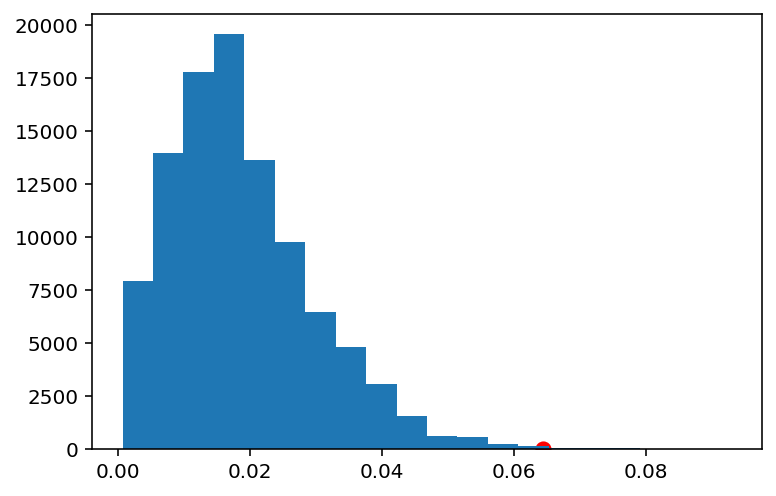

In [852]:
plt.hist(sim_tvds, bins=20)
plt.scatter(obs_tvd, 0, color='red', s=50);

As we can see, the observed TVD is an outlier, with simulated values more extreme than it only occurring less than 1% of the time. Our significance level was 0.01, so we reject the null hypothesis - the distribution of causes of outages post-2006 is not the same as the distribution of causes of outages pre-2006.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

import time
import datetime
from scipy.stats import ks_2samp

### Cleaning and EDA

In [117]:
def outage_xlsx_to_df():
    outage_raw = pd.read_excel('./outage.xlsx')
    outage_raw.columns = outage_raw.iloc[4]
    outage = outage_raw.drop(range(6), axis=0).reset_index().drop(columns=['variables', 'OBS', 'index'])
    outage.columns.name = None
    return outage

In [898]:
def combine_times(outage):
    temp = outage.get(['OUTAGE.START.DATE', 'OUTAGE.START.TIME'])
    outage['OUTAGE.START.DATETIME'] = pd.to_datetime(
        temp['OUTAGE.START.DATE'].dropna().apply(str).apply(lambda x: x.split()[0]) 
        + ' ' 
        + temp['OUTAGE.START.TIME'].dropna().apply(str))
    
    temp = outage.get(['OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME'])
    outage['OUTAGE.RESTORATION.DATETIME'] = pd.to_datetime(
        temp['OUTAGE.RESTORATION.DATE'].dropna().apply(str).apply(lambda x: x.split()[0]) 
        + ' ' 
        + temp['OUTAGE.RESTORATION.TIME'].dropna().apply(str))
    outage = outage.drop(columns=['RES.PRICE',
                                  'COM.PRICE',
                                  'IND.PRICE',
                                  'RES.SALES',
                                  'COM.SALES',
                                  'IND.SALES',
                                  'RES.PERCEN',
                                  'COM.PERCEN',
                                  'IND.PERCEN',
                                  'RES.CUSTOMERS',
                                  'COM.CUSTOMERS',
                                  'IND.CUSTOMERS',
                                  'OUTAGE.START.DATE', 
                                  'OUTAGE.START.TIME', 
                                  'OUTAGE.RESTORATION.DATE', 
                                  'OUTAGE.RESTORATION.TIME',
                                  'PC.REALGSP.CHANGE',
                                  #'UTIL.REALGSP',
                                  #'UTIL.CONTRI',
                                  'PI.UTIL.OFUSA',
                                  #'YEAR',
                                  'MONTH',
                                  'POSTAL.CODE',
                                  'ANOMALY.LEVEL',
                                  #'CAUSE.CATEGORY.DETAIL',
                                  'RES.CUST.PCT',
                                  'COM.CUST.PCT',
                                  'IND.CUST.PCT',
                                  'AREAPCT_URBAN',
                                  'AREAPCT_UC',
                                  'PCT_LAND',
                                  'PCT_WATER_TOT',
                                  'PCT_WATER_INLAND'])
    return outage

In [432]:
def fix_duration(outage):
    outage['OUTAGE.DURATION'] = outage['OUTAGE.RESTORATION.DATETIME'] - outage['OUTAGE.START.DATETIME']
    return outage

In [901]:
def fix_types(outage):
    nan_inserter = lambda x: np.NaN if np.isnan(x) else float(x)
    for obj_col in outage.columns:
        if obj_col not in ['U.S._STATE', 'NERC.REGION', 'CLIMATE.REGION', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY',
                           'HURRICANE.NAMES', 'OUTAGE.DURATION', 'OUTAGE.START.DATETIME', 
                           'OUTAGE.RESTORATION.DATETIME', 'CAUSE.CATEGORY.DETAIL']:
            outage = outage.assign(**{obj_col: outage[obj_col].apply(nan_inserter).astype(float)})
    return outage

In [902]:
outage = outage_xlsx_to_df()

In [903]:
outage = combine_times(outage)
outage = fix_duration(outage)
outage = fix_types(outage)

In [436]:
mpo = lambda row: row['CUSTOMERS.AFFECTED'] > 50_000 or row['DEMAND.LOSS.MW'] > 300
outage = outage.assign(**{'MAJOR.POWER.OUTAGE': outage.apply(mpo, axis=1)})

In [171]:
loss_by_region = (outage.get(['DEMAND.LOSS.MW', 'NERC.REGION'])
                  .assign(**{'DEMAND.LOSS.MW.NOTNULL': outage['DEMAND.LOSS.MW'].notnull()})
                  .groupby('NERC.REGION').mean())
loss_by_region

,DEMAND.LOSS.MW,PCT_CUSTOMERS_AFFECTED,DEMAND.LOSS.MW.NOTNULL
NERC.REGION,,,
ASCC,35.000000,0.052181,1.000000
ECAR,1314.483871,0.056895,0.911765
FRCC,804.450000,0.031696,0.909091
"FRCC, SERC",NaN,NaN,0.000000
HECO,466.666667,0.273349,1.000000
HI,1060.000000,0.622848,1.000000
MRO,279.500000,0.044697,0.434783
NPCC,930.123288,0.031454,0.486667
PR,220.000000,0.129633,1.000000


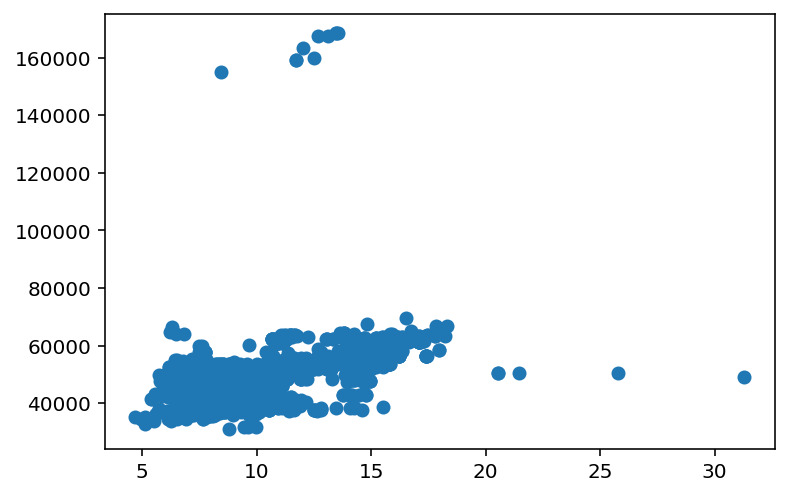

In [239]:
plt.scatter(outage['TOTAL.PRICE'], outage['PC.REALGSP.STATE'])

In [244]:
outage_climate = (outage.get(['NERC.REGION', 'CLIMATE.REGION', 'CLIMATE.CATEGORY', 'OUTAGE.DURATION', 
                             'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED', 'MAJOR.POWER.OUTAGE'])
                 )
outage_by_region = (outage_climate.groupby('CLIMATE.REGION').mean())
outage_by_category = (outage_climate.groupby('CLIMATE.CATEGORY').mean())

In [245]:
display(outage_by_climate)
display(outage_by_category)

,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,MAJOR.POWER.OUTAGE
CLIMATE.REGION,,,
Central,477.481928,126809.872611,0.640000
East North Central,560.405797,138388.932203,0.753623
Northeast,537.410714,121960.011278,0.497143
Northwest,177.896552,81420.000000,0.227273
South,399.086538,183500.774194,0.510917
Southeast,761.532787,180539.538462,0.699346
Southwest,424.555556,39028.911111,0.195652
West,651.456790,194579.893939,0.451613
West North Central,326.000000,47316.000000,0.294118


,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,MAJOR.POWER.OUTAGE
CLIMATE.CATEGORY,,,
cold,391.028000,126840.066869,0.501057
normal,574.796954,153182.834286,0.506720
warm,657.854749,146843.895652,0.545455


### Assessment of Missingness

In [ ]:
# Also, Rhode Island is not in outage['U.S._STATE']

In [190]:
def tvd_missingness_pval(df, m_col, c_col, n_trials, want_hist):
    """
    m_col: column with missing values
    c_col: column being tested for correlations to missing values
    n_trials: number of trials run for permutation test
    """
    n_rows = df.shape[0]
    temp_df = df.get([m_col, c_col])
    temp_df = temp_df.assign(**{'m_col_null': temp_df[m_col].isnull(), 
                                'm_col_notnull': temp_df[m_col].notnull()})
    m_by_c_col = temp_df.groupby(c_col).mean().get(['m_col_null', 'm_col_notnull'])
    obs_tvd = m_by_c_col.diff(axis=1).iloc[:,-1].abs().sum() / 2    
    
    sim_tvds = []
    for _ in range(n_trials):
        temp_df = temp_df.assign(**{'shuffled_m_col': np.random.permutation(temp_df[m_col])})
        temp_df = temp_df.assign(**{'shuffled_m_col_null': temp_df['shuffled_m_col'].isnull(), 
                                    'shuffled_m_col_notnull': temp_df['shuffled_m_col'].notnull()})
        shuffled_m_by_c_col = temp_df.groupby(c_col).mean().get(['shuffled_m_col_null', 'shuffled_m_col_notnull'])
        sim_tvd = shuffled_m_by_c_col.diff(axis=1).iloc[:, -1].abs().sum() / 2
        sim_tvds.append(sim_tvd)
    
    if want_hist:
        plt.hist(sim_tvds, bins=30)
        print(obs_tvd)
    
    return np.count_nonzero(np.array(sim_tvds) >= obs_tvd) / n_trials

In [870]:
def ks_missingness_pval(df, m_col, c_col, n_trials, want_hist):
    """
    m_col: column with missing values
    c_col: column being tested for correlations to missing values
    n_trials: number of trials run for permutation test
    """
    temp_df = df.get([m_col, c_col])
    m_col_null = temp_df[temp_df[m_col].isnull()][c_col]
    m_col_notnull = temp_df[temp_df[m_col].notnull()][c_col]
    if (m_col_null.shape[0] != 0 and m_col_notnull.shape[0] != 0):
        obs_ks = ks_2samp(m_col_null, m_col_notnull).statistic
    else:
        obs_ks = 0
    
    sim_kss = []
    for _ in range(n_trials):
        temp_df = temp_df.assign(**{'shuffled_m_col': np.random.permutation(temp_df[m_col].isnull())})
       
        shuffled_m_col_null = temp_df.loc[temp_df['shuffled_m_col'], c_col]
        shuffled_m_col_notnull = temp_df.loc[~temp_df['shuffled_m_col'], c_col]
        
        if (shuffled_m_col_null.shape[0] != 0 and shuffled_m_col_notnull.shape[0] != 0):
            sim_ks = ks_2samp(shuffled_m_col_null, shuffled_m_col_notnull).statistic
            sim_kss.append(sim_ks)
        else:
            sim_kss.append(0)
    
    if want_hist:
        plt.hist(sim_kss, bins=30)
        print(obs_ks)
    
    return np.count_nonzero(np.array(sim_kss) >= obs_ks) / n_trials

In [ ]:
# finding MCAR column

In [904]:
outage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype          
---  ------                       --------------  -----          
 0   YEAR                         1534 non-null   float64        
 1   U.S._STATE                   1534 non-null   object         
 2   NERC.REGION                  1534 non-null   object         
 3   CLIMATE.REGION               1528 non-null   object         
 4   CLIMATE.CATEGORY             1525 non-null   object         
 5   CAUSE.CATEGORY               1534 non-null   object         
 6   CAUSE.CATEGORY.DETAIL        1063 non-null   object         
 7   HURRICANE.NAMES              72 non-null     object         
 8   OUTAGE.DURATION              1476 non-null   timedelta64[ns]
 9   DEMAND.LOSS.MW               829 non-null    float64        
 10  CUSTOMERS.AFFECTED           1091 non-null   float64        
 11  TOTAL.PRICE                  1

In [913]:
discrete_columns_r = ['U.S._STATE', 'NERC.REGION', 'CLIMATE.REGION', 'CLIMATE.CATEGORY','CAUSE.CATEGORY', 
                      'CAUSE.CATEGORY.DETAIL', 'HURRICANE.NAMES']
continuous_columns_r = ['DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED', 'TOTAL.PRICE', 'TOTAL.SALES', 
                        'TOTAL.CUSTOMERS', 'PC.REALGSP.STATE', 'PC.REALGSP.USA', 'PC.REALGSP.REL', 
                        'UTIL.REALGSP', 'TOTAL.REALGSP', 'UTIL.CONTRI', 'POPULATION', 'POPPCT_URBAN', 'POPPCT_UC', 
                        'POPDEN_URBAN', 'POPDEN_UC', 'POPDEN_RURAL', 'OUTAGE.START.DATETIME', 
                        'OUTAGE.RESTORATION.DATETIME']

In [910]:
randcol_dependencies_tvd = {col: tvd_missingness_pval(outage, 
                                                           'OUTAGE.DURATION', col, 250, False) 
                                  for col in discrete_columns_r}

In [911]:
display(randcol_dependencies_tvd)

{'U.S._STATE': 0.808,
 'NERC.REGION': 0.668,
 'CLIMATE.REGION': 0.816,
 'CLIMATE.CATEGORY': 0.92,
 'CAUSE.CATEGORY': 1.0,
 'CAUSE.CATEGORY.DETAIL': 1.0,
 'HURRICANE.NAMES': 0.076}

In [914]:
randcol_dependencies_ks = {col: ks_missingness_pval(outage,
                                                         'OUTAGE.DURATION', col, 250, False) 
                                for col in continuous_columns_r}

In [915]:
display(randcol_dependencies_ks)

{'DEMAND.LOSS.MW': 0.232,
 'CUSTOMERS.AFFECTED': 0.296,
 'TOTAL.PRICE': 0.0,
 'TOTAL.SALES': 0.008,
 'TOTAL.CUSTOMERS': 0.3,
 'PC.REALGSP.STATE': 0.064,
 'PC.REALGSP.USA': 0.0,
 'PC.REALGSP.REL': 0.264,
 'UTIL.REALGSP': 0.196,
 'TOTAL.REALGSP': 0.504,
 'UTIL.CONTRI': 0.056,
 'POPULATION': 0.376,
 'POPPCT_URBAN': 0.48,
 'POPPCT_UC': 0.12,
 'POPDEN_URBAN': 0.22,
 'POPDEN_UC': 0.024,
 'POPDEN_RURAL': 0.0,
 'OUTAGE.START.DATETIME': 0.0,
 'OUTAGE.RESTORATION.DATETIME': 0.0}

In [ ]:
# end of finding MCAR

In [549]:
discrete_columns = ['U.S._STATE', 'NERC.REGION', 'CLIMATE.REGION', 'CLIMATE.CATEGORY','CAUSE.CATEGORY']
continuous_columns = ['OUTAGE.DURATION', 'CUSTOMERS.AFFECTED', 'TOTAL.PRICE', 'TOTAL.SALES', 'TOTAL.CUSTOMERS', 
                      'PC.REALGSP.STATE', 'PC.REALGSP.USA', 'PC.REALGSP.REL', 'UTIL.REALGSP', 'TOTAL.REALGSP', 
                      'UTIL.CONTRI', 'POPULATION', 'POPPCT_URBAN', 'POPPCT_UC', 'POPDEN_URBAN', 'POPDEN_UC', 
                      'POPDEN_RURAL', 'OUTAGE.START.DATETIME', 'OUTAGE.RESTORATION.DATETIME']

In [862]:
demandlossmw_dependencies_tvd = {col: tvd_missingness_pval(outage, 
                                                           'DEMAND.LOSS.MW', col, 200, False) 
                                  for col in discrete_columns}
demandlossmw_dependencies_ks = {col: ks_missingness_pval(outage,
                                                         'DEMAND.LOSS.MW', col, 200, False) 
                                for col in continuous_columns}

In [556]:
control_for_ca_tvd = {col: tvd_missingness_pval(outage[outage['U.S._STATE'] == 'California'], 
                                                'DEMAND.LOSS.MW', col, 1000, False) 
                      for col in discrete_columns}
control_for_tx_tvd = {col: tvd_missingness_pval(outage[outage['U.S._STATE'] == 'Texas'], 
                                                'DEMAND.LOSS.MW', col, 1000, False) 
                      for col in discrete_columns}
control_for_mi_tvd = {col: tvd_missingness_pval(outage[outage['U.S._STATE'] == 'Michigan'], 
                                                'DEMAND.LOSS.MW', col, 1000, False) 
                      for col in discrete_columns}

In [558]:
control_for_ca_ks = {col: ks_missingness_pval(outage[outage['U.S._STATE'] == 'California'], 
                                              'DEMAND.LOSS.MW', col, 1000, False) 
                     for col in continuous_columns}
control_for_tx_ks = {col: ks_missingness_pval(outage[outage['U.S._STATE'] == 'Texas'], 
                                              'DEMAND.LOSS.MW', col, 1000, False) 
                     for col in continuous_columns}
control_for_mi_ks = {col: ks_missingness_pval(outage[outage['U.S._STATE'] == 'Michigan'], 
                                              'DEMAND.LOSS.MW', col, 1000, False) 
                     for col in continuous_columns}                      

In [573]:
tvds_states = {}
ds = [control_for_ca_tvd, control_for_tx_tvd, control_for_mi_tvd]
for k in control_for_ca_tvd.keys():
    tvds_states[k] = tuple(d[k] for d in ds)
for k in tvds_states.keys():
    tvds_states[k] = list(tvds_states[k])
    
kss_states = {}
ds = [control_for_ca_ks, control_for_tx_ks, control_for_mi_ks]
for k in control_for_ca_ks.keys():
    kss_states[k] = tuple(d[k] for d in ds)
for k in kss_states.keys():
    kss_states[k] = list(kss_states[k])

In [577]:
tvds_kss_states = {}
for k in tvds_states.keys():
    tvds_kss_states[k] = tvds_states[k]
for k in kss_states.keys():
    tvds_kss_states[k] = kss_states[k]

In [598]:
demandlossmw_dependencies_all = {}
for k in demandlossmw_dependencies_tvd.keys():
    demandlossmw_dependencies_all[k] = demandlossmw_dependencies_tvd[k]
for k in demandlossmw_dependencies_ks.keys():
    demandlossmw_dependencies_all[k] = demandlossmw_dependencies_ks[k]

states = pd.DataFrame(data=tvds_kss_states, index=['California', 'Texas', 'Michigan']).transpose()
pvals_all = pd.DataFrame(demandlossmw_dependencies_all, index=['ALL'])
pvals_all = pvals_all.transpose()
pvals_compare = pd.concat([states, pvals_all], axis=1)
pvals_compare_filtered = (pvals_compare.astype(np.float16).drop(index=['NERC.REGION', 'U.S._STATE']))

In [587]:
(
    outage.pivot_table(values='DEMAND.LOSS.MW', 
                   index='U.S._STATE', 
                   columns='YEAR', 
                   aggfunc='count')
    .fillna(0).astype(np.int)
    .loc[['California', 'Texas', 'Michigan']]
)

YEAR,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
U.S._STATE,,,,,,,,,,,,,,,,,
California,1,7,5,4,10,9,8,12,19,10,21,10,6,12,5,15,4
Texas,2,1,0,3,6,4,8,3,4,6,1,12,6,0,0,3,1
Michigan,0,0,1,8,5,6,2,4,3,3,5,9,3,2,0,0,0


In [736]:
def imputer(outage, imp_col):
    """
    uses probabilistic imputation by U.S._STATE (which is never null)
    Strategy: consider the df formed by selecting rows where DEMAND.LOSS.MW is missing. Fix the state. 
    Then find the CAUSE.CATEGORY of the outage (which is never null), and impute from those values.
    """
    imp_outage = outage.copy()
    states = imp_outage['U.S._STATE'].unique()
    
    for state in states:
        outage_state = imp_outage[imp_outage['U.S._STATE'] == state]
        causes = outage_state['CAUSE.CATEGORY'].unique()
        for cause in causes:
            if outage_state.shape[0] != 0:
                imputed = cause_imputer(outage_state, imp_col, cause)
                imp_outage.loc[imputed.index, :] = imputed
            else:
                # since no values here are null
                continue
            
    return imp_outage

In [737]:
def cause_imputer(outage_state, imp_col, cause):    
    outage_state_cause = outage_state[outage_state['CAUSE.CATEGORY'] == cause]
    num_null = outage_state_cause[imp_col].isnull().sum()
    notnull_col = outage_state_cause[imp_col].dropna()
    if notnull_col.shape[0] != 0:
        fill_values = notnull_col.sample(num_null, replace=True)
        fill_values.index = outage_state_cause.loc[outage_state_cause[imp_col].isnull()].index
        imp_outage = outage_state_cause.fillna({imp_col: fill_values.to_dict()})
        return imp_outage
    else:
        # I don't feel comfortable imputing with potentially wildly differing values from true, so I'll drop these
        return outage_state

In [706]:
(outage.pivot_table(values='DEMAND.LOSS.MW', 
                    index='CAUSE.CATEGORY', 
                    columns='U.S._STATE', 
                    aggfunc='mean')
 .fillna(0)
 .astype(int)
 .transpose()
 .loc[['California', 'Texas', 'Michigan', 'Washington', 'New York']]
)

CAUSE.CATEGORY,equipment failure,fuel supply emergency,intentional attack,islanding,public appeal,severe weather,system operability disruption
U.S._STATE,,,,,,,
California,375,635,31,551,8638,412,335
Texas,378,1231,2,0,0,736,615
Michigan,336,0,0,0,8881,318,4197
Washington,244,630,0,94,100,430,200
New York,0,468,0,0,76,336,6975


In [735]:
(outage.pivot_table(values='CUSTOMERS.AFFECTED', 
                    index='CAUSE.CATEGORY', 
                    columns='U.S._STATE', 
                    aggfunc='mean')
 .fillna(0)
 .astype(int)
 .transpose()
 .loc[['California', 'Texas', 'Michigan', 'Washington', 'New York']]
)

CAUSE.CATEGORY,equipment failure,fuel supply emergency,intentional attack,islanding,public appeal,severe weather,system operability disruption
U.S._STATE,,,,,,,
California,198608,0,10660,5039,0,361041,152040
Texas,85882,0,552,0,0,258094,289696
Michigan,0,0,0,0,0,138311,759737
Washington,93300,0,0,0,8000,182676,0
New York,0,0,0,0,18600,165050,1080998


In [742]:
imputed_outage = imputer(outage, 'DEMAND.LOSS.MW')
imputed_outage = imputer(imputed_outage, 'CUSTOMERS.AFFECTED')
imputed_outage = imputed_outage[imputed_outage['DEMAND.LOSS.MW'].notnull()]
imputed_outage = imputed_outage[imputed_outage['CUSTOMERS.AFFECTED'].notnull()]

In [778]:
mpo_causes = (imputed_outage.pivot_table(values='MAJOR.POWER.OUTAGE', 
                                         index='CAUSE.CATEGORY', 
                                         columns='YEAR', 
                                         aggfunc='sum')
              .fillna(0)
              .astype(np.int)
)
mpo_causes

YEAR,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
CAUSE.CATEGORY,,,,,,,,,,,,,,,,,
equipment failure,1,0,0,4,2,2,0,1,2,4,1,1,0,3,0,0,0
fuel supply emergency,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
intentional attack,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,2
islanding,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
public appeal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
severe weather,5,0,11,28,45,34,40,29,50,30,42,69,34,30,18,28,9
system operability disruption,3,5,1,5,2,3,6,2,8,1,2,7,0,2,0,3,5


### Hypothesis Test

In [ ]:
# TODO
# null hypothesis: distribution of causes before 2006 is the same as the distribution of causes after 2006
# alternative hypothesis: they're different

In [781]:
mpo_causes_before_2006 = mpo_causes.get([2000, 2001, 2002, 2003, 2004, 2005, 2006])
mpo_causes_after_2006 = mpo_causes.get([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

mpo_props_before_2006 = (mpo_before_2006.sum(axis=1) / mpo_before_2006.sum().sum())
mpo_props_after_2006 = mpo_after_2006.sum(axis=1) / mpo_after_2006.sum().sum()

In [788]:
mpo_before_2006.sum().sum(), mpo_after_2006.sum().sum()

(197, 388)

In [818]:
def hypothesis_test(n_trials):
    obs_tvd = (mpo_props_before_2006 - mpo_props_after_2006).abs().sum() / 2
    sim_tvds = []
    n_outages_after_2006 = mpo_after_2006.sum().sum()
    for _ in range(n_trials):
        sim_outages = np.random.multinomial(n_outages_after_2006, mpo_props_before_2006)
        sim_props = sim_outages / sim_outages.sum()
        sim_tvds.append((mpo_props_before_2006 - sim_props).abs().sum() / 2)
    # pval
    return np.count_nonzero(sim_tvds >= obs_tvd) / n_trials, sim_tvds, obs_tvd

In [826]:
pval, sim_tvds, obs_tvd = hypothesis_test(100_000)

In [827]:
pval

0.00108

(array([1.753e+03, 2.311e+03, 6.342e+03, 5.568e+03, 4.295e+03, 8.756e+03,
        7.364e+03, 6.138e+03, 7.311e+03, 6.759e+03, 4.650e+03, 6.157e+03,
        6.962e+03, 2.980e+03, 2.839e+03, 4.760e+03, 3.004e+03, 1.228e+03,
        2.449e+03, 1.941e+03, 6.290e+02, 1.339e+03, 1.244e+03, 1.540e+02,
        8.100e+02, 7.310e+02, 4.560e+02, 2.600e+01, 3.370e+02, 2.460e+02,
        3.000e+01, 1.310e+02, 1.190e+02, 9.000e+00, 5.600e+01, 4.600e+01,
        1.200e+01, 1.700e+01, 1.700e+01, 8.000e+00, 1.000e+00, 9.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([0.00070647, 0.0024983 , 0.00429013, 0.00608195, 0.00787378,
        0.0096656 , 0.01145743, 0.01324925, 0.01504108, 0.01683291,
        0.01862473, 0.02041656, 0.02220838, 0.02400021, 0.02579204,
        0.02758386, 0.02937569, 0.03116751, 0.03295934, 0.03475116,
        0.03654299, 0.03833482, 0.04012664, 0.04191847, 0.04371029,
        0.04550212, 0.04729395, 0.04

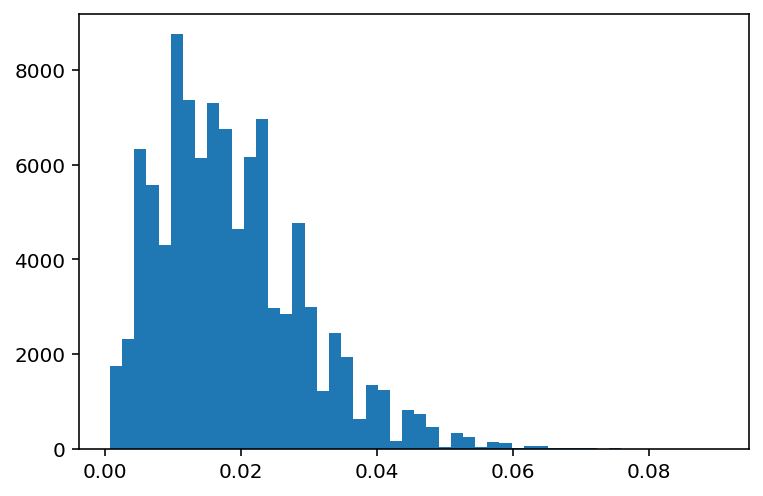

In [829]:
plt.hist(sim_tvds, bins=50)